Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far. 

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

Fun with categorical variables
    0 or 1 value
    
Changing variable types
    We can also take a continuous variable and make it categorical.
    
Categorical, Ordinal, Interval, Ratio

Combining two or more highly-correlated variables

Dealing with non-normality
    Transform to normal
    
Creating linear relationships

Making variables easier to understand in light of the research question

Leveling the playing field

All about interactions

GlobalEventID
SQLDATE
AvgTone
QuadClass 
Goldstein Scale - 
NumMentions (normalize by overall mentions going on) - Ratio
IsRootEvent - Categorical
EventBaseCode
Actor1Geo_ADM1Code/Actor2Geo_ADM1Code/ActionGeo_ADM1Code

SOURCEURL and Tone

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map
        
data_2008 = "./200811.csv"
data_2016 = "./20161108.export.CSV"

In [3]:
interest = ["GLOBALEVENTID", "SQLDATE", "AvgTone", "QuadClass", "GoldsteinScale",
           "NumMentions", "IsRootEvent", "EventBaseCode", 
            #"Actor1Code", "Actor2Code",
            "Actor1CountryCode", "Actor2CountryCode",
            #"Actor1KnownGroupCode", "Actor2KnownGroupCode",
            #"Actor1EthnicCode", "Actor2EthnicCode",
            "Actor1Religion1Code", "Actor2Religion1Code",
            "Actor1Type1Code", "Actor2Type2Code",
            "Actor1Geo_ADM1Code", "Actor2Geo_ADM1Code", "ActionGeo_ADM1Code"]

In [4]:
df_2008 = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], 
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])
df_2016 = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, 
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])

In [5]:
df_2008.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'Actor1CountryCode', 'Actor1Religion1Code',
       'Actor1Type1Code', 'Actor2CountryCode', 'Actor2Religion1Code',
       'Actor2Type2Code', 'IsRootEvent', 'EventBaseCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'AvgTone', 'Actor1Geo_ADM1Code',
       'Actor2Geo_ADM1Code', 'ActionGeo_ADM1Code'],
      dtype='object')

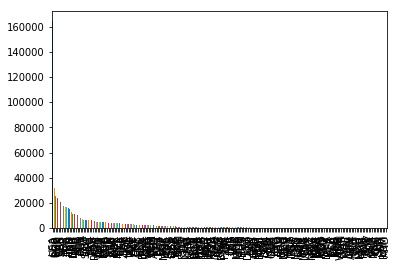

In [6]:
df_2008['Actor1CountryCode'].dropna().value_counts().plot(kind="bar")

In [7]:
df_2008['Actor1CountryCode'].dropna()

2720       AFG
2721       AFG
2722       AFG
2723       AFG
2724       AFG
2725       AFG
2726       AFG
2727       AFG
2728       AFG
2729       AFG
2730       AFG
2731       AFG
2732       AFG
2733       AFG
2734       AFG
2735       AFG
2736       AFG
2737       AFG
2738       AFG
2739       AFG
2740       AFG
2741       AFG
2742       AFG
2743       AFG
2744       AFG
2745       AFG
2746       AFG
2747       AFG
2748       AFG
2749       AFG
          ... 
1211171    USA
1211172    USA
1211173    USA
1211174    USA
1211175    VEN
1211176    VEN
1211177    VEN
1211178    VEN
1211179    VEN
1211180    VEN
1211181    VEN
1211182    VEN
1211183    VEN
1211184    VEN
1211185    VEN
1211186    VEN
1211187    VEN
1211188    VEN
1211189    VEN
1211190    VNM
1211191    ZWE
1211192    ZWE
1211193    ZWE
1211194    ZWE
1211195    ZWE
1211196    ZWE
1211197    ZWE
1211198    ZWE
1211199    ZWE
1211200    ZWE
Name: Actor1CountryCode, Length: 719918, dtype: category
Categories (216, object): [A

In [8]:
df_2008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211209 entries, 0 to 1211208
Data columns (total 17 columns):
GLOBALEVENTID          1211209 non-null uint32
SQLDATE                1211209 non-null datetime64[ns]
Actor1CountryCode      719918 non-null category
Actor1Religion1Code    19965 non-null category
Actor1Type1Code        518870 non-null category
Actor2CountryCode      575234 non-null category
Actor2Religion1Code    19159 non-null category
Actor2Type2Code        27066 non-null category
IsRootEvent            1211209 non-null bool
EventBaseCode          1211209 non-null object
QuadClass              1211209 non-null uint8
GoldsteinScale         1211209 non-null float32
NumMentions            1211209 non-null uint16
AvgTone                1211209 non-null float32
Actor1Geo_ADM1Code     1084618 non-null category
Actor2Geo_ADM1Code     876006 non-null category
ActionGeo_ADM1Code     1189493 non-null category
dtypes: bool(1), category(9), datetime64[ns](1), float32(2), object(1), u

In [32]:
for col in df_2008.columns:
    if df_2008[col].dtype.name == 'category':
        #print(col, len(df_2008[col].cat.categories))
        no_na = df_2008[col].dropna().copy()
        #print(no_na)
        enough_data = no_na.value_counts() \
                        [(no_na.value_counts()/ \
                            no_na.value_counts().sum()) > 0.005]
        #print(df_2008[col].isin(enough_data.index))
        #print(df_2008[col])
        print(df_2008[col][df_2008[col].isin(enough_data.index)].value_counts())

USA    164654
GBR     32047
RUS     25368
CHN     23813
PAK     21312
CAN     21094
AUS     17967
ISR     17386
AFG     16862
IRQ     16748
FRA     16208
IND     15515
IRN     12662
EUR     11092
DEU     10945
PSE     10828
AFR     10730
JPN      8013
PHL      7978
TUR      7138
THA      6564
EGY      6428
SOM      6271
IRL      6258
SAU      6124
SYR      6094
ESP      5788
RWA      5408
IDN      5199
LBN      4782
        ...  
MLI         0
MKD         0
MEA         0
MDV         0
MCO         0
POL         0
PRK         0
PRT         0
TJK         0
UZB         0
URY         0
UKR         0
UGA         0
TZA         0
TUN         0
TTO         0
TMP         0
TKM         0
TCD         0
QAT         0
SYC         0
SWE         0
SVK         0
SUR         0
SRB         0
SLV         0
SLB         0
SGP         0
SEN         0
MLT         0
Name: Actor1CountryCode, Length: 216, dtype: int64
MOS    10799
CHR     5103
JEW     2297
HIN      988
BUD      347
NRM      179
SIK      140
TAO 

GLOBALEVENTID AxesSubplot(0.042173,0.807813;0.276922x0.176562) uint32
SQLDATE AxesSubplot(0.365861,0.807813;0.276922x0.176562) datetime64[ns]
Actor1CountryCode AxesSubplot(0.68955,0.807813;0.276922x0.176562) category
Actor1Religion1Code AxesSubplot(0.042173,0.610706;0.276922x0.176562) category
Actor1Type1Code AxesSubplot(0.365861,0.610706;0.276922x0.176562) category
Actor2CountryCode AxesSubplot(0.68955,0.610706;0.276922x0.176562) category
Actor2Religion1Code AxesSubplot(0.042173,0.4136;0.276922x0.176562) category
Actor2Type2Code AxesSubplot(0.365861,0.4136;0.276922x0.176562) category
IsRootEvent AxesSubplot(0.68955,0.4136;0.276922x0.176562) bool
EventBaseCode AxesSubplot(0.042173,0.216493;0.276922x0.176562) object
QuadClass AxesSubplot(0.365861,0.216493;0.276922x0.176562) uint8
GoldsteinScale AxesSubplot(0.68955,0.216493;0.276922x0.176562) float32
NumMentions AxesSubplot(0.042173,0.0193866;0.276922x0.176562) uint16
AvgTone AxesSubplot(0.365861,0.0193866;0.276922x0.176562) float32
Acto

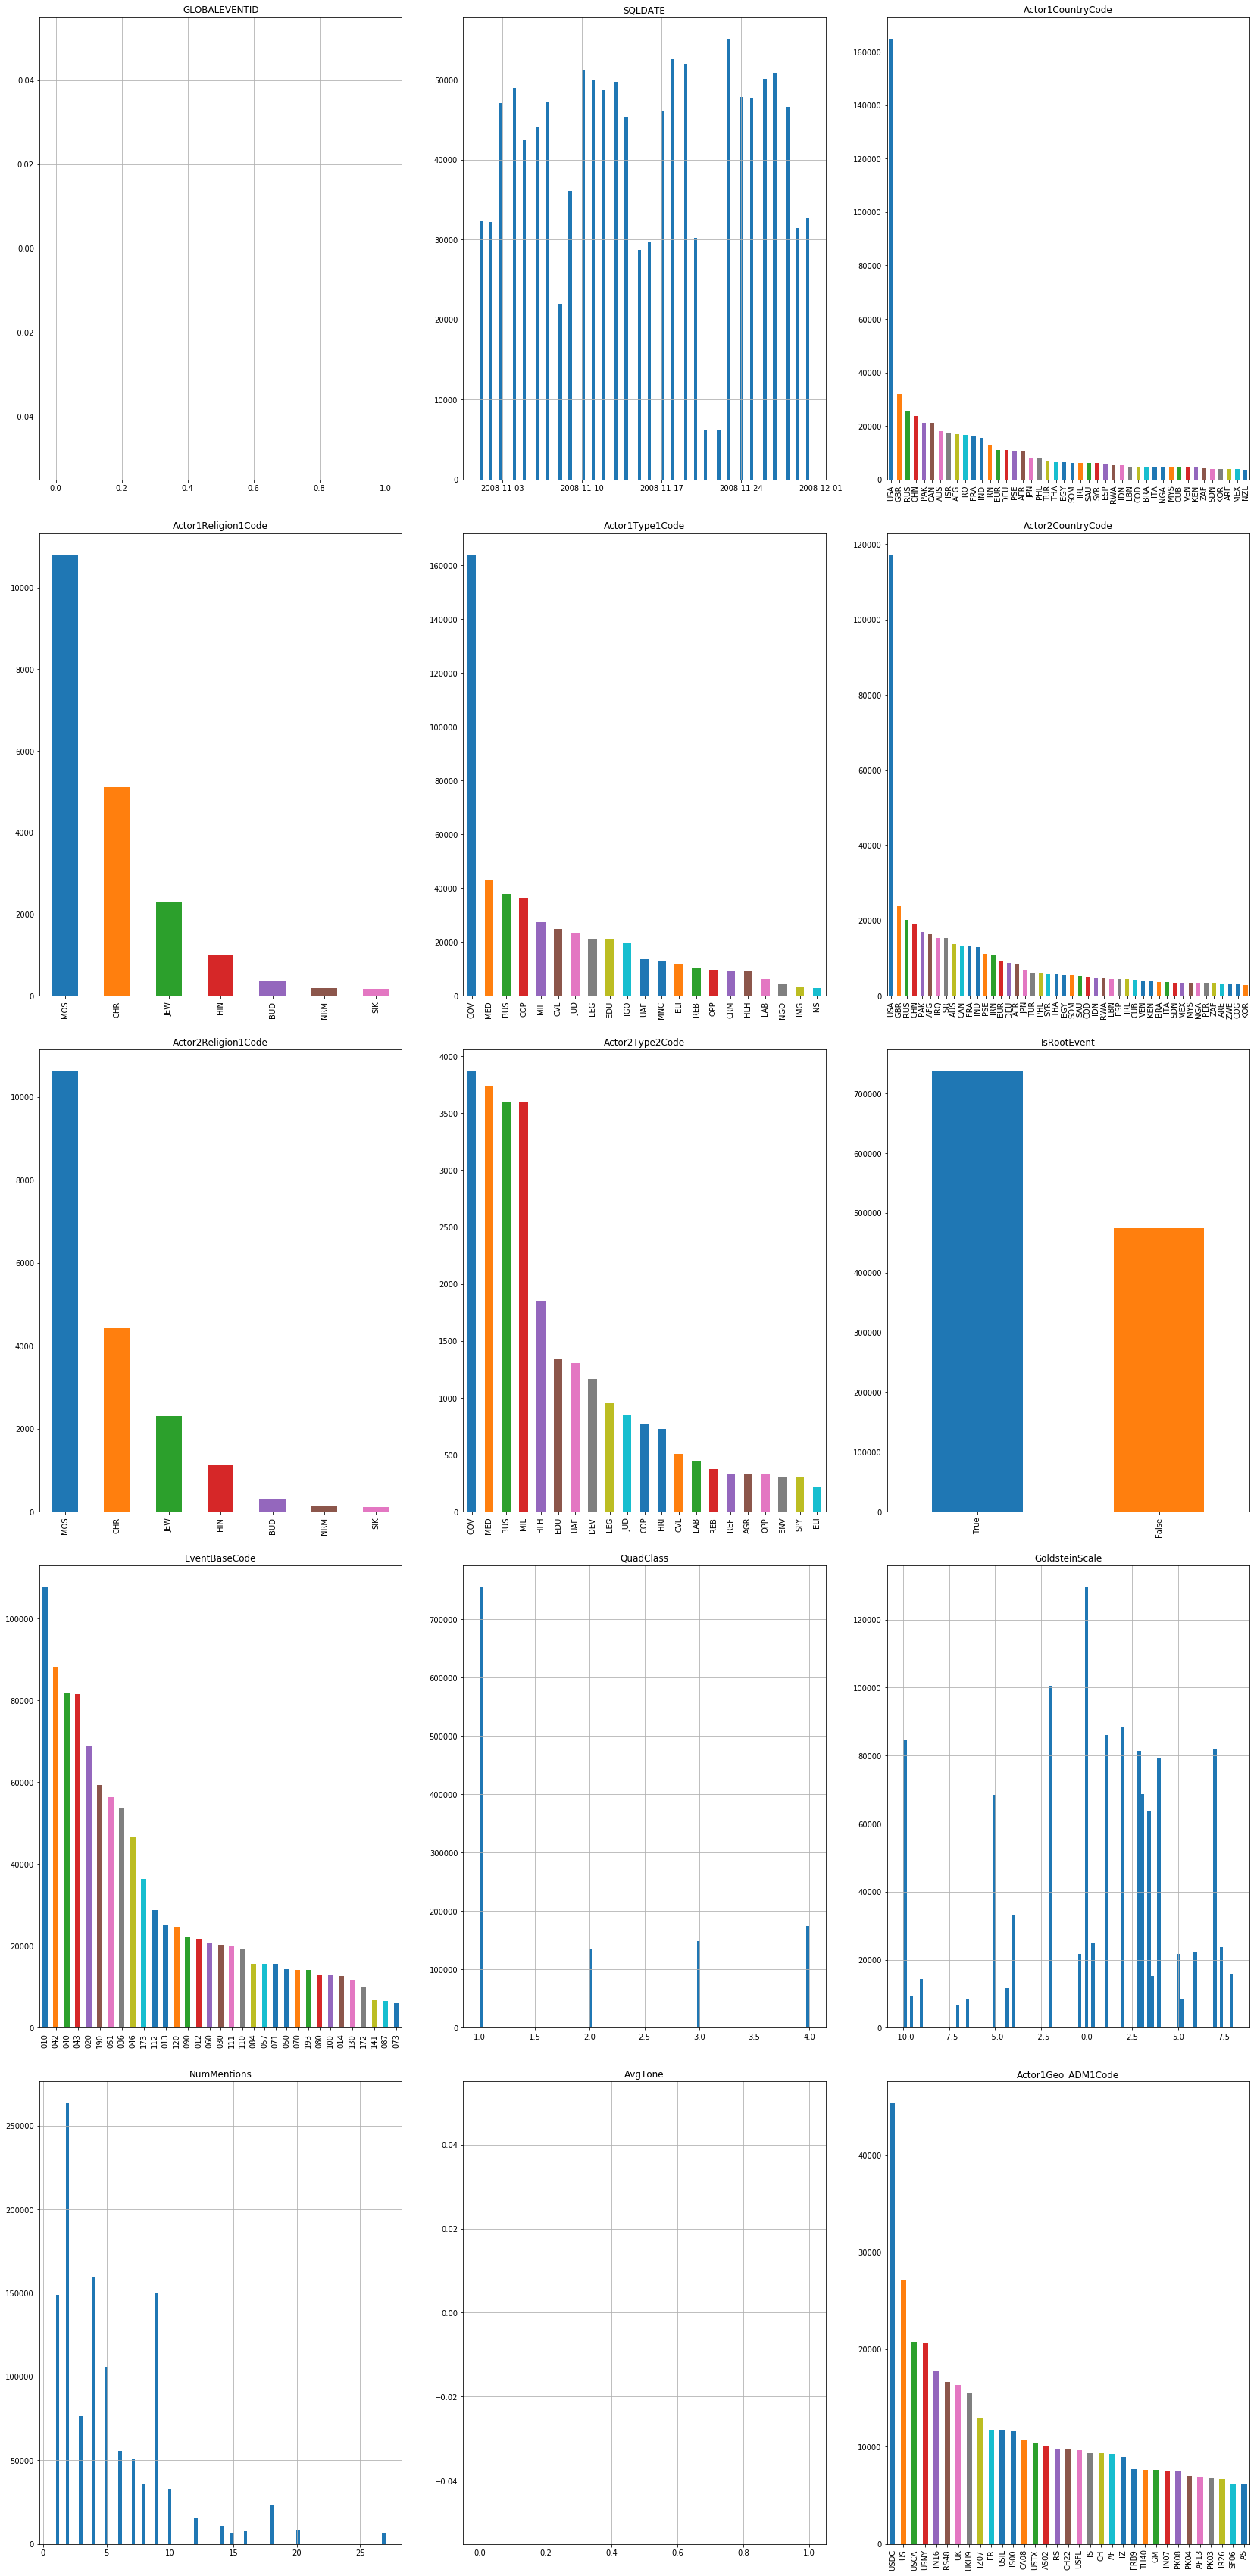

In [33]:
# https://stackoverflow.com/questions/39646070/pandas-histogram-plot-histogram-for-each-column-as-subplot-of-a-big-figure
fig, axes = plt.subplots(len(df_2008.columns)//3, 3, figsize=(24, 48))
plt.tight_layout(pad=5, w_pad=5, h_pad=5)
for col, axis in zip(df_2008.columns, axes.flatten()):
    no_na = df_2008[col].dropna().copy()
    enough_data = no_na.value_counts() \
                    [(no_na.value_counts()/ \
                        no_na.value_counts().sum()) > 0.005]
    df_2008_graph = df_2008[col][df_2008[col].isin(enough_data.index)]
    dtype_name = df_2008_graph.dtype.name
    print(col, axis, dtype_name)
    axis.set_title(col)
    if dtype_name == 'category' or dtype_name == 'bool' \
            or dtype_name == 'object':
        if dtype_name == 'category':
            df_2008_graph.cat.remove_unused_categories() \
                        .value_counts().plot(kind="bar", ax=axis)
        else:
            df_2008_graph.value_counts().plot(kind="bar", ax=axis)
    else:
        df_2008_graph.hist(bins = 100, ax=axis)

Keep differentiation for like the 10 in a category and then collapse all others in to "Other".